### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
import string
import re

from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
seed = np.random.seed(7) # fix random seed for reproducibility

### Load Data

In [3]:
with open("NonZoonoticVirusesTrain.fasta") as f:
    NonZoo_raw_data  = f.read()
    
with open("ZoonoticVirusesTrain.fasta") as g:
    Zoo_raw_data  = g.read()
    
with open("VirusesTestInput.fasta") as h:
    test_raw_data  = h.read()

### Explore Data

In [4]:
NonZoodata = NonZoo_raw_data.split(">")
Zoodata = Zoo_raw_data.split(">")
testdata = test_raw_data.split(">")

# dump the empty string in position [0]
NonZoodata2 = NonZoodata[1:]
Zoodata2 = Zoodata[1:]
testdata2 = testdata[1:]

In [5]:
NonZoo_new_data = [x.split(",") for x in NonZoodata2]
Zoo_new_data = [x.split(",") for x in Zoodata2]
test_new_data = [x.split(",") for x in testdata2]

NonZoo_id_name = []
Zoo_id_name = []
test_id_name = []
NonZoo_genome_sequence = []
Zoo_genome_sequence = []
test_genome_sequence = []

for x in NonZoo_new_data:
    NonZoo_id_name.append(x[0])
    NonZoo_genome_sequence.append(x[1])
    
for x in Zoo_new_data:
    Zoo_id_name.append(x[0])
    Zoo_genome_sequence.append(x[1])
    
for x in test_new_data:
    test_id_name.append(x[0])
    test_genome_sequence.append(x[1])

### Preprocessing Data

In [6]:
def clean_id_names(text):
    id_and_names = text.split(' ',1)
    return id_and_names

In [7]:
ZooID_Description = []
NonZooID_Description = []
testID_Description = []
for x in Zoo_id_name:
    ZooID_Description.append(clean_id_names(x))
for x in NonZoo_id_name:
    NonZooID_Description.append(clean_id_names(x)) 
for x in test_id_name:
    testID_Description.append(clean_id_names(x))

In [8]:
Zoo_ID = []
Zoo_Description = []

for x in ZooID_Description:
    Zoo_ID.append(x[0])
    Zoo_Description.append(x[1])
    
NonZoo_ID = []
NonZoo_Description = []

for x in NonZooID_Description:
    NonZoo_ID.append(x[0])
    NonZoo_Description.append(x[1])
    
test_ID = []
test_Description = []

for x in testID_Description:
    test_ID.append(x[0])
    test_Description.append(x[1])

### Clean the Sequences

In [9]:
def clean_text(text):
    
    remove_lower = lambda text: re.sub('[a-z]', '', text)
    
    text = remove_lower(text)
    text = text.strip()
    text = text.replace('\n', '')
    return text

In [10]:
NonZoo_clean_sequences = []
Zoo_clean_sequences = []
test_clean_sequences = []
for seq in NonZoo_genome_sequence:
    NonZoo_clean_sequences.append(clean_text(seq))
    
for seq in Zoo_genome_sequence:
    Zoo_clean_sequences.append(clean_text(seq))
    
for seq in test_genome_sequence:
    test_clean_sequences.append(clean_text(seq))

In [11]:
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

def onelistmaker(n):
    listofzeros = [1] * n
    return listofzeros

In [12]:
Zoolabels = zerolistmaker(len(Zoo_clean_sequences)) #Zootonic viruses as Class 0.
NonZoolabels = onelistmaker(len(NonZoo_clean_sequences)) #NonZootonic viruses as Class 1.

In [13]:
Zoo_data_frame = [list(x) for x in zip(Zoo_ID,Zoo_Description,Zoo_clean_sequences,Zoolabels)]
NonZoo_data_frame = [list(x) for x in zip(NonZoo_ID,NonZoo_Description,NonZoo_clean_sequences,NonZoolabels)]
test_data_frame = [list(x) for x in zip(test_ID,test_Description,test_clean_sequences)]
trainlist = Zoo_data_frame + NonZoo_data_frame
dataframe = pd.DataFrame(trainlist, columns = ['ID' , 'Description', 'Sequences', 'Labels'])
dataframe.head()

,ID,Description,Sequences,Labels
0,NC_003466.1,Andes virus segment S,TAGTAGTAGACTCCTTGAGAAGCTACTGCTGCGAAAGCTGGAATGA...,0
1,NC_003468.2,Andes virus segment L,TAGTAGTAGACTCCGGGATAGAAAAAGTTAGAAAAATGGAAAAGTA...,0
2,NC_003467.2,Andes virus segment M,TAGTAGTAGACTCCGCAAGAAGAAGCAAAAAATTAAAGAAGTGAGT...,0
3,NC_009026.2,Bussuquara virus,AGTATTTCTTCTGCGTGAGACCATTGCGACAGTTCGTACCGGTGAG...,0
4,NC_004211.1,Banna virus strain JKT-6423 segment 1,GTATTAAAAATTATCAACAAGGAATGGACATTCAAGAACAATTTGA...,0


In [14]:
df = dataframe[['Sequences', 'Labels']]

In [15]:
df['Labels'].value_counts()

1    70
0    70
Name: Labels, dtype: int64

In [16]:
df['char_length'] = df['Sequences'].str.len()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1370fc7f0>]],
      dtype=object)

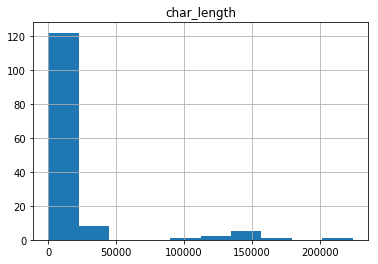

In [17]:
df.hist('char_length')

In [18]:
def sequence_description(df):    
#     print(df['Sequences'][0])
    print('Median value is: ' + str(df.Sequences.str.len().median()))
    print('Mean value is: ' + str(df.Sequences.str.len().mean()))
    print('Max value is: ' + str(df.Sequences.str.len().max()))

In [19]:
text_info_per_language(df)

Median value is: 3906.0
Mean value is: 16833.285714285714
Max value is: 224499


In [20]:
dfone = df[df['Labels'] == 1].reset_index()

In [21]:
dfzero = df[df['Labels'] == 0].reset_index()

In [22]:
text_info_per_language(dfone)

Median value is: 4198.5
Mean value is: 20550.2
Max value is: 170101


In [23]:
len(dfone[dfone.Sequences.str.len() > 20550])

13

In [24]:
dfone[dfone.Sequences.str.len() > 20550]

,index,Sequences,Labels,char_length
12,82,TATAAGTATATTATATATTTTATAATTTTATATATATAAAGCAGGT...,1,170101
17,87,ACCATAAACTATCTAAATAAGCACTTTTCTGGCTCTCTGGCCCCCC...,1,130608
18,88,CGGGTCCGGAGATGTCGGGACCAGGGTCCCTGCTTCTCGGGACGCG...,1,137090
28,98,TTTTGCCCCGGGGGAAGGTAGGGGCAAACACACCCCTGGGGCTAGA...,1,147346
55,125,CATCATCAATAATATACGGAACACTTTTGCGTGATGACGTTGACGT...,1,34185
56,126,CATCATCAATAATCTACAGTACACTGATGGCAGCGGTCCAACTGCC...,1,34446
57,127,CATCATCAATAATCTACAGTACACTGATGGCAGCGGTCCAACTGCC...,1,34446
58,128,CATTCATATATATTAACATGCACCGGGGGCGTGGCGCGGCCATTTT...,1,31301
59,129,CATTCATATATAATAACATGCACAGGGGCGTGGCGCGGCCATTTTG...,1,30024
61,131,GATTGCGAGCGATTTGCGTGCGTGCATCCCGCTTCACTGATCTCTT...,1,31028


In [25]:
text_info_per_language(dfzero)

Median value is: 3657.0
Mean value is: 13116.371428571429
Max value is: 224499


In [26]:
len(dfzero[dfzero.Sequences.str.len() > 20550])

5

In [27]:
df_train = df['Sequences'].apply(lambda x: pd.Series(list(x)))

In [28]:
df['Divisible'] = df['char_length'] % 3

In [29]:
df['Divisible']

0      2
1      1
2      2
3      0
4      0
5      0
6      0
7      1
8      0
9      0
10     1
11     0
12     0
13     2
14     2
15     0
16     0
17     0
18     2
19     0
20     0
21     0
22     1
23     0
24     2
25     1
26     0
27     0
28     2
29     2
      ..
110    0
111    1
112    0
113    0
114    2
115    0
116    2
117    0
118    2
119    2
120    1
121    0
122    0
123    0
124    0
125    0
126    0
127    0
128    2
129    0
130    0
131    2
132    2
133    2
134    1
135    0
136    1
137    1
138    1
139    1
Name: Divisible, Length: 140, dtype: int64

In [28]:
char_set = pd.concat(map(df_.get, df_.columns)).reset_index(drop=True)

In [ ]:
set(char_set)

In [30]:
dna_dict = {'A':1, 'C':2, 'G':3, 'T':4}

In [31]:
df_prep = df['Sequences'].str.pad(20550, side='left', fillchar='0').to_frame()

In [32]:
text_info_per_language(df_prep)

Median value is: 20550.0
Mean value is: 30391.957142857143
Max value is: 224499


In [33]:
dfs = df_prep['Sequences'].apply(lambda x: pd.Series(list(x)))

In [34]:
dfs.shape

(140, 224499)

In [35]:
dfs.head()

,0,1,2,3,4,5,6,7,8,9,...,224489,224490,224491,224492,224493,224494,224495,224496,224497,224498
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
dfs = dfs.iloc[:,0:20550]

In [37]:
dfs.head()

,0,1,2,3,4,5,6,7,8,9,...,20540,20541,20542,20543,20544,20545,20546,20547,20548,20549
0,0,0,0,0,0,0,0,0,0,0,...,C,A,T,A,C,T,A,C,T,A
1,0,0,0,0,0,0,0,0,0,0,...,C,A,T,A,C,T,A,C,T,A
2,0,0,0,0,0,0,0,0,0,0,...,C,A,T,A,C,T,A,C,T,A
3,0,0,0,0,0,0,0,0,0,0,...,A,C,C,A,G,A,T,T,C,T
4,0,0,0,0,0,0,0,0,0,0,...,T,A,G,A,A,C,T,G,A,C


In [38]:
#Map the character dictionary created above to the dataframe.
dfs = dfs.applymap(dna_dict.get)

In [39]:
dfs.head()

,0,1,2,3,4,5,6,7,8,9,...,20540,20541,20542,20543,20544,20545,20546,20547,20548,20549
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,4.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,4.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,4.0,1.0,2.0,4.0,1.0,2.0,4.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,2.0,1.0,3.0,1.0,4.0,4.0,2.0,4.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,1.0,3.0,1.0,1.0,2.0,4.0,3.0,1.0,2.0


In [40]:
dfs.replace(np.NaN, '0')

,0,1,2,3,4,5,6,7,8,9,...,20540,20541,20542,20543,20544,20545,20546,20547,20548,20549
0,0,0,0,0,0,0,0,0,0,0,...,2,1,4,1,2,4,1,2,4,1
1,0,0,0,0,0,0,0,0,0,0,...,2,1,4,1,2,4,1,2,4,1
2,0,0,0,0,0,0,0,0,0,0,...,2,1,4,1,2,4,1,2,4,1
3,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,3,1,4,4,2,4
4,0,0,0,0,0,0,0,0,0,0,...,4,1,3,1,1,2,4,3,1,2
5,0,0,0,0,0,0,0,0,0,0,...,1,3,1,1,2,2,2,3,1,2
6,0,0,0,0,0,0,0,0,0,0,...,4,1,3,1,1,2,4,3,1,2
7,0,0,0,0,0,0,0,0,0,0,...,4,4,3,1,2,2,2,3,1,2
8,0,0,0,0,0,0,0,0,0,0,...,4,1,3,1,1,2,4,3,1,2
9,0,0,0,0,0,0,0,0,0,0,...,1,4,4,3,1,2,4,3,1,2


In [41]:
dfs.shape

(140, 20550)

In [42]:
dfs = dfs.fillna(0)

In [43]:
x = dfs.as_matrix()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [44]:
y = df['Labels'].to_frame().as_matrix()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

In [46]:
num_chars = 5

In [47]:
embedding_vector_length = x.shape[1]

### Model

In [48]:
# create the model
# embedding_vecor_length = 32
model = Sequential()
# model.add(Dense(32, input_shape=(3906,)))
#The embedding matrix has the shape of num of unique words/chars x length of string that will be passed in.
model.add(Embedding(num_chars, 100, input_length=embedding_vector_length))
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(LSTM(25))
# model.add(Dense())

model.add(LSTM(250, return_sequences = True))
model.add(LSTM(250, return_sequences = True))
model.add(LSTM(50))

model.add(Dense(1, activation='sigmoid'))

# model.add(LSTM(32, input_shape=(112,embedding_vector_length)))
# model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20550, 100)        500       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20550, 250)        351000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 20550, 250)        501000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 912,751
Trainable params: 912,751
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 11

In [50]:
# create the model
# embedding_vecor_length = 32
model = Sequential()
# model.add(Dense(32, input_shape=(3906,)))
#The embedding matrix has the shape of num of unique words/chars x length of string that will be passed in.
model.add(Embedding(num_chars, 300, input_length=embedding_vector_length))
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(100))
# model.add(LSTM(30))
model.add(Dense(1, activation='sigmoid'))

# model.add(LSTM(32, input_shape=(112,embedding_vector_length)))
# model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20550, 300)        1500      
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 162,001
Trainable params: 162,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 112 samples, validate on 28 samples
Epoch 1/3
112/112 [==============================] - 84s 749ms/step - loss: 0.6946 - acc: 0.5089 - val_loss: 0.7040 - val_acc: 0.3929
Epoch 2/3
112/112 [==============================] - 81s 724ms/step - loss: 0.6898 - acc: 0.5357 - val_loss: 0.7069 - val_acc: 0.3929
Epoch 3/3
112/112 [==============================] - 82s 732ms/step - loss: 0.6839

In [ ]:
model.add(Dense())

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

### Result Functions

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Main Method

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_holdout, y_holdout, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# Final evaluation of the model
scores = model.evaluate(x_holdout, y_holdout, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)